In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
import torch

In [136]:
from dataclasses import dataclass
import torch.nn as nn

@dataclass
class HarmonicSpheres:
    weights: list[int]
    spheres: torch.Tensor
    weights: torch.Tensor

    def __init__(self, npoints=100):
        phi = np.linspace(0, np.pi, npoints)
        theta = np.linspace(0, 2*np.pi, npoints)
        phi, theta = np.meshgrid(phi, theta)
        self.x = np.sin(phi) * np.cos(theta)
        self.y = np.sin(phi) * np.sin(theta)
        self.z = np.cos(phi)

        self.weights = torch.rand((3, 9))

        self.spheres = torch.empty((9, npoints, npoints))

        harmonic_cf = [[0, 0], [1, 1], [0, 1], [-1, 1], [2, 2], [1, 2], [0,2], [-1, 2], [-2, 2]]
        for i, [m, l] in enumerate(harmonic_cf):
            self.spheres[i, :, :] = torch.tensor(sph_harm(m, l, theta, phi).real)

    def get_total(self):
        weights = self.weights
        npoints = self.spheres.shape[1]

        res = torch.ones((npoints, npoints, 4))
        res[:, :, :3] = (weights @ self.spheres.reshape((9, npoints*npoints))).T.reshape(npoints, npoints, 3)
        resmin, resmax = res[:, :, :3].min(), res[:, :, :3].max()
        res[:, :, :3] = (res[:, :, :3] - resmin) / (resmax - resmin)
        res[:, :, :3] = nn.Softmax(2)(res[:, :, :3])
        return res

    def get_cartesian(self):
        return self.x, self.y, self.z

In [159]:
# input: point on the sphere (theta, phi)
# output: color (rgba)

import torch.nn as nn

class SphereNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.spheres = HarmonicSpheres()
        self.weights = nn.Parameter(self.spheres.weights, requires_grad=True)
        self.npoints = self.spheres.spheres.shape[1]

    def forward(self):
        spheres = self.spheres.spheres
        res = torch.ones((self.npoints, self.npoints, 4))
        res[:, :, :3] = (self.weights @ spheres.view((9, self.npoints*self.npoints))).T.view(self.npoints, self.npoints, 3)
        res[:, :, :3] = nn.Softmax(2)(res[:, :, :3])
        return res

In [200]:
import torch.optim as optim

spheres = HarmonicSpheres(100)
spheres.weights[0, :] = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0, 0])
spheres.weights[1, :] = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 0])
spheres.weights[2, :] = torch.tensor([0, 0, 0, 0, 1, 0, 0, 0, 0])

target = spheres.get_total()

model = SphereNet()

loss_fn = nn.MSELoss()
optim = optim.SGD(model.parameters(), lr=0.3)
epochs = 3000

for epoch in range(epochs):
    optim.zero_grad()

    out = model()
    loss = loss_fn(out, target)

    loss.backward()
    optim.step()

    if epoch % 100 == 0:
        print(loss.item())


0.005946001503616571
0.00429377518594265
0.0030715062748640776
0.00219043530523777
0.0015673828311264515
0.001131198019720614
0.0008262491901405156
0.0006118353921920061
0.00045946435420773923
0.00034969818079844117
0.0002694391878321767
0.00020987758762203157
0.0001650552439969033
0.00013089658750686795
0.00010457336611580104
8.409081056015566e-05
6.80185912642628e-05
5.531410715775564e-05
4.5206274080555886e-05
3.7117162719368935e-05
3.0608975066570565e-05
2.5346696929773316e-05
2.107205000356771e-05
1.7584372471901588e-05
1.4726696463185363e-05
1.2375597179925535e-05
1.0433641364215873e-05
8.823520147416275e-06
7.4836148087342735e-06
6.364601631503319e-06


tensor([[ 1.0038,  0.4204,  0.2282,  0.3623,  0.1566,  0.8555,  0.5286,  0.5148,
          0.3818],
        [-0.0118,  0.0732,  1.2410,  0.0266,  0.1780,  0.9437,  0.5329,  0.6027,
          0.3789],
        [ 0.0118,  0.3636,  0.2335,  0.3366,  0.3677,  0.6678,  0.5115,  0.3221,
          1.1054]])


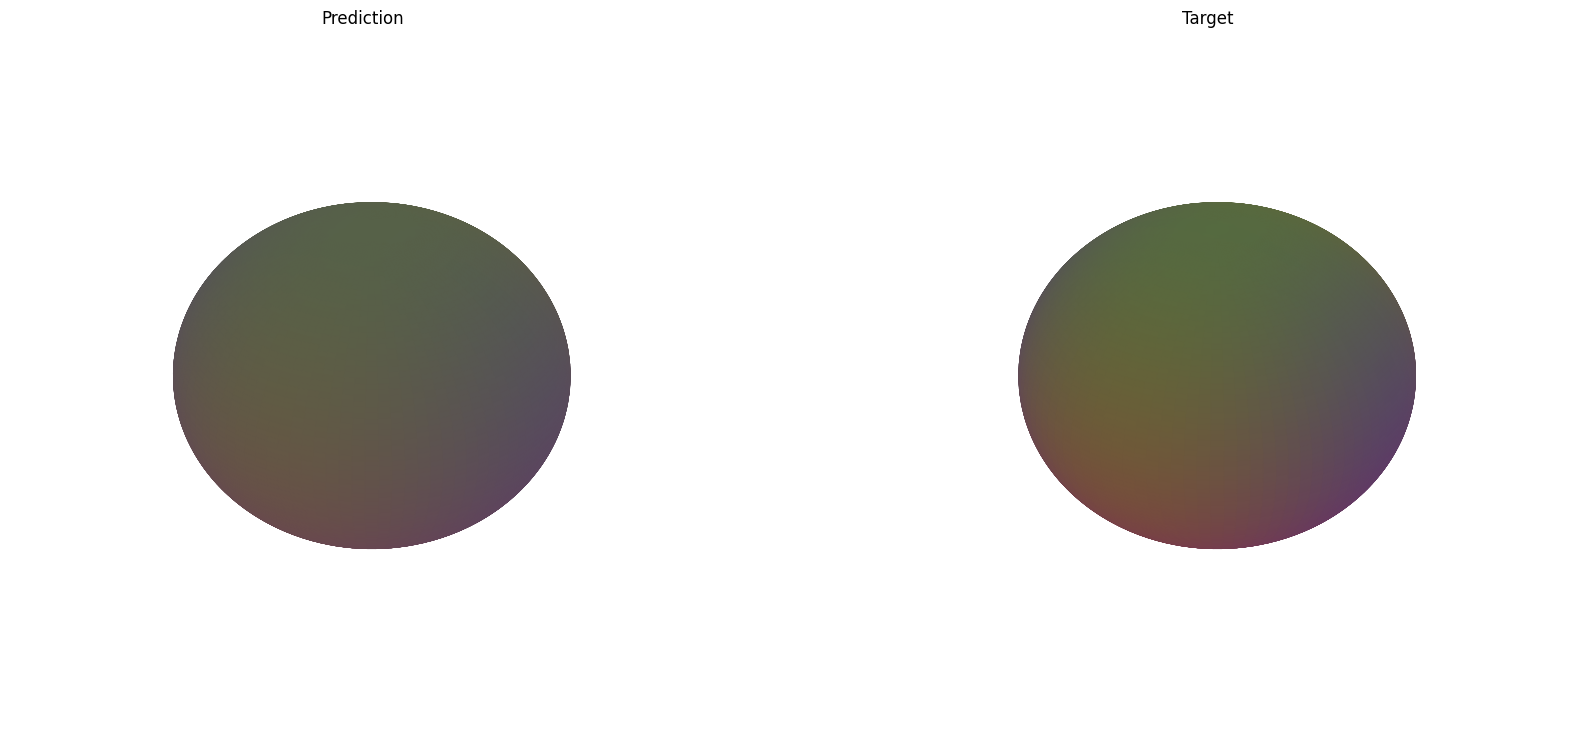

In [201]:
spheres = HarmonicSpheres(100)

predcolors = model.spheres.get_total().numpy()
targcolors = target.numpy()
x,y,z = spheres.get_cartesian()

print(model.spheres.weights)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=predcolors, shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=targcolors, shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()